In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import enviroment_no_visual as enviroment_no_visual
import enviroment_visual as enviroment_visual
import tensorflow as tf
import keras

pygame 2.6.0 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-10-10 11:39:35.509488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 11:39:35.526399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 11:39:35.576081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 11:39:35.709930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 11:39:35.743947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 11:39:35.807818: I tensorflow/core/platform/cpu_feature_gu

Implementazione di un buffer circolare che permetta inserimento/cancellazione degli elementi e accesso random veloce. 

In [2]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size, zeta=0.6):
        self.max_size = max_size
        self.buffer = []
        self.zeta = zeta
        self.priorities =  np.zeros((max_size,), dtype=np.float32)
        self.index = 0

    def append(self, experience):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.max_size:
            self.buffer.append(experience)
        else:
            self.buffer[self.index] = experience
        self.priorities[self.index] = max_priority
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.max_size:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.index]
        
        probabilities = priorities ** self.zeta
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        
        total = len(self.buffer)
        sampling_probabilities = probabilities[indices]
        weights = (total * sampling_probabilities) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones, indices, weights


    def update_priorities(self, batch_indices, batch_errors):
        for i, error in zip(batch_indices, batch_errors):
            self.priorities[i] = np.abs(error) + 1e-5

Funzione per creare una neural network lineare 

In [3]:
def Linear_QNet():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[11]))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(3))
    return model

In [4]:
model = Linear_QNet()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,843 (15.01 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class DQNetwork:
    def __init__(self, lr, gamma):
        self.model = Linear_QNet()
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.loss_fn = keras.losses.mean_squared_error

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones, weights):
        next_Q_values = self.model(next_states)
        max_next_Q_values = tf.reduce_max(next_Q_values, axis=1)
        # Equazione di Bellman: Q value = reward + discount factor * expected future reward
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)  
            Q_values = tf.reduce_sum(all_Q_values * actions, axis=1, keepdims=False)
            loss = tf.reduce_mean(weights * self.loss_fn(target_Q_values, Q_values))
        # Backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        td_errors = tf.abs(tf.subtract(target_Q_values, Q_values))
        return td_errors

    def save_model(self, model_dir_path="./DQNmodel/CNN", file_name='model.keras'):
        if not os.path.exists(model_dir_path):
            print(f"La cartella non esiste. Sarà creata con nome: {model_dir_path}")
            os.mkdir(model_dir_path)
        file_name = os.path.join(model_dir_path, file_name)
        self.model.save(file_name)

In [6]:
def convert_to_tensorflow(states, actions, rewards, next_states, dones):
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    dones = tf.convert_to_tensor(dones, dtype=tf.float32)
    return states, actions, rewards, next_states, dones

In [7]:
class Agent:
    def __init__(self, lr, gamma, max_memory, batch_size, visual=True):
        self.n_games = 0
        self.epsilon = 1
        self.batch_size = batch_size
        self.memory = PrioritizedReplayBuffer(max_size=max_memory, zeta=0.6)
        self.dqnetwork = DQNetwork(lr=lr, gamma=gamma)
        self.env = enviroment_visual.SnakeGameAI(speed=0) if visual else enviroment_no_visual.SnakeGameAI()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append(convert_to_tensorflow(state, action, reward, next_state, done))

    def train_memory(self, beta=0.4):
        if len(self.memory.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones, indices, weights = self.memory.sample(self.batch_size, beta)
        td_errors = self.dqnetwork.train_step(states, actions, rewards, next_states, dones, weights)
        self.memory.update_priorities(indices, td_errors.numpy())

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        else:
            Q_values = self.dqnetwork.model(state[np.newaxis])
            return np.argmax(Q_values[0])
        
    def get_action(self, state):
        final_move = [0, 0, 0]  
        move = self.epsilon_greedy_policy(state)
        final_move[move] = 1
        return final_move
    
    def train_agent(self, N_GAME):
        score_list = []
        record = 0
        step=0
        n_eps_zero = int(N_GAME*0.7)
        while self.n_games < N_GAME:
            state_old = self.env.get_state()
            final_move = self.get_action(state_old)
            state_new, reward, done, score = self.env.play_step(final_move)
            self.remember(state_old, final_move, reward, state_new, done)
            if done:
                self.env.reset()
                self.n_games += 1
                self.train_memory()
                print(f"\rGame: {self.n_games}, Epsilon: {self.epsilon:3f}, Score: {score}, Record: {record}, Step eseguiti: {step}. ", end="")
                self.epsilon = max(((n_eps_zero - self.n_games) / n_eps_zero), 0)
                if score > record:
                    record = score
                    self.dqnetwork.save_model()
                score_list.append(score)
            step+=1
        return score_list

Mostra andamento dello score per partita durante il training

In [8]:
def plot_trend(scores, save_path=None):
    plt.plot(scores, label='Score')
    plt.title("Andamento del training")
    plt.xlabel("Partite")
    plt.ylabel("Score")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Crea e allena un agente

Game: 500, Epsilon: 0.000000, Score: 17, Record: 65, Step eseguiti: 94401. 

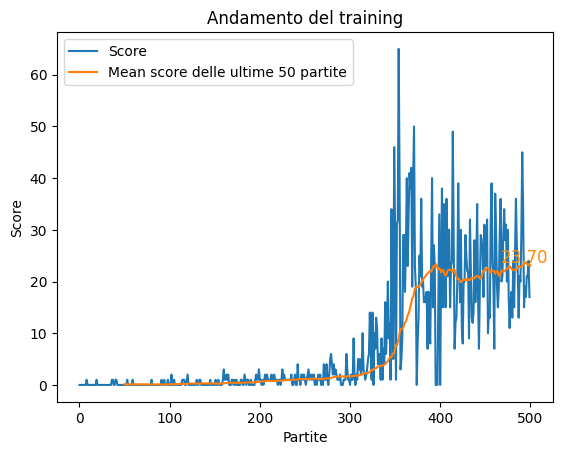

: 

In [9]:
agent = Agent(lr=0.001, gamma=0.9, max_memory=50_000, batch_size=1024, visual=True)
training_result = agent.train_agent(N_GAME=500)
plot_trend(training_result)